# Importing libs

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as tickers
import seaborn as sns
from math import *
from scipy.interpolate import interp1d

%matplotlib inline

# Stress x Strain - Eurocode

| <img width=500 src='Equations.jpg'> | <img width=500 src='Graph.jpg'> |

## Function definition

In [18]:
def stress(e,temp,fp,fy,Ea):
    '''
    inputs:
    e: current strain value;
    temp: current temperature value in Celsius;
    fp: strength on the proportional limit at 20 C in Pa;
    fy: yield strength at 20 C in Pa
    Ea: Young modulus at 20 C in Pa
    '''

    #Definition of parameters
    
    
    fp20=fpi 
    fy20=fyi 
    Ea20= Eai 

    #Reduction factors deppending on temperature 
    # See Table 3.1
    X = [0,20,100,200,300,400,500,600,700,800,900,1000,1100,1200]
    ky = [1,1,1,1,1,1,0.78,0.47,0.23,0.11,0.06,0.04,0.02,0]
    kp = [1,1,1,0.807,0.613,0.42,0.36,0.18,0.075,0.050,0.0375,0.025,0.0125,0]
    kE = [1,1,1,0.9,0.8,0.7,0.6,0.31,0.13,0.09,0.0675,0.0450,0.0225,0]

    #Interpolation for intermediate values
    fky = interp1d(X,ky,kind='linear')
    fkp = interp1d(X,kp,kind='linear')
    fkE = interp1d(X,kE,kind='linear')

    #Applying the reduction factor to fyi,fpi,Eai to get theta values e.g for each temperature

    fy = fy20 * fky(temp) * 1
    fp = fp20 * fkp(temp) * 1
    Ea = Ea20 * fkE(temp) * 1
    
    

    ep=fp/Ea
    ey=0.02
    et=0.15
    eu=0.2

    ## Auxiliary functions 
    def Fc(fy,fp,ey,ep,Ea):
        return ((fy-fp)**2)/((ey-ep)*Ea-(2*(fy-fp)))

    def Fa2(ey,ep,Ea):
        c=Fc(fy,fp,ey,ep,Ea)
        return (ey-ep)*(ey-ep+(c/Ea))

    def Fb2(ey,ep,Ea):
        c=Fc(fy,fp,ey,ep,Ea)
        return c*(ey-ep)*Ea+c**2

    #Strain ranges 
    if e<=ep:
        return e*Ea

    elif ep<e<ey:
        
        c=Fc(fy,fp,ey,ep,Ea)
        a2=Fa2(ey,ep,Ea)
        b2=Fb2(ey,ep,Ea)
        a=sqrt(a2)
        b=sqrt(b2)

        return fp-c+(b/a)*(a2-(ey-e)**2)**0.5
    
    elif ey<=e<=et:
        return fy
    
    elif et<e<eu:
        return fy*(1-(e-et)/(eu-et))
    
    elif e==eu:
        return 0
    else:
        pass

## Calculate

In [16]:
#Material definitions
fpi=252.18e6
fyi=600e6
Eai = 525.18e6/0.0025


emax = 0.04 #Max strain to calculate
points = 50 #number of points to calculate
strains = np.linspace(0,emax,points,endpoint=True)

#Alternativley create a list with desired strains e.g:
#strains = [0,0.0025,0.0226,0.0419,0.0609,0.0798,0.0981,0.1044]

#Temperatures to evaluate
#20 to 1200
temperatures = [20,100,200]

strain_t = []
for temp in temperatures:
    strain_t.append(np.array([stress(e,temp,fpi,fyi,Eai) for e in strains]))


## Plot

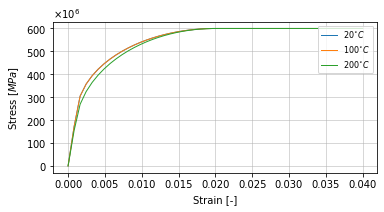

In [17]:
##create figure and set its size
fig = plt.figure(figsize=(6,3)) 


##add a axes (blank area to plot data)
ax = fig.add_subplot(1,1,1) 
plt.subplots_adjust(bottom=0.18,left=0.15)

#Set the name of the axes
#ax.set_title("Name of the plot", fontsize=14)

#Plot data

for temp,i in zip(temperatures,range(len(strain_t))):
    ax.plot(strains,strain_t[i],linewidth=1,label=str(temp)+'$^{\circ}C$')


plt.plot()
#ax.scatter(x,y,label="Put the label here")
ax.legend(loc='upper right',fontsize=8)


ax.grid(b=True,which='major',linewidth=0.5)


#Axis labels
ax.set_xlabel('Strain [-]',fontsize=10,labelpad=5)
ax.set_ylabel("Stress [$MPa$]", fontsize=10,labelpad=5)
ax.ticklabel_format(axis="y",style="sci",scilimits=(6,6),useMathText=True)


#Save fig
#fig.savefig("Steel_strain_stress_temperature.pdf",format='pdf')

## Export to CSV

In [19]:
df = pd.DataFrame(strains,columns=['strain'])

for temp,i in zip(temperatures,range(len(strain_t))):
    df[temp] = pd.Series(strain_t[i])
df.head()

,strain,20,100,200
0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000816,1.714873e+08,1.714873e+08,1.543386e+08
2,0.001633,3.047577e+08,3.047577e+08,2.690659e+08
3,0.002449,3.572633e+08,3.572633e+08,3.243235e+08
4,0.003265,3.935149e+08,3.935149e+08,3.643331e+08
